# Ntuple preprocessing

**Goal:** Take the root [file]() with track time from Lorenzo, and get it ready for ML studies!!

1. Open the root file
2. Apply some standard FTAG cuts
3. Visualize
4. ML preprocessing


In [2]:
import numpy as np
import pandas as pd
from random import shuffle
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import h5py

import glob
import os
import sys
from tqdm import tqdm

# from skhep.math.vectors import LorentzVector, Vector3D
import uproot
import xarray as xr

# from usefulFcts import nJetsTag, getIPTag, strToList, VR

2023-02-27 16:17:49.956830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorfl

## Step 1: Open the root file

In [3]:
fName = 'data/hadded.root'
f = uproot.open(fName)

In [4]:
for k in f.keys():
    print(k)

EventTree;1
EventLoop_FileExecuted;1
EventLoop_JobStats;1
EventLoop_RunTime;1
EventLoop_EventCount;1


In [5]:
tName = 'EventTree'
t = f[tName]

Check what's inside the tree

In [6]:
for k in t.keys():
    print(k)

mcChannelNumber
EventNumber
RunNumber
BCID
mu
muActual
beamspot_x
beamspot_y
beamspot_z
beamspot_sigX
beamspot_sigY
beamspot_sigZ
met_Truth
mpx_Truth
mpy_Truth
sumet_Truth
track_prob
track_d0
track_z0
track_theta
track_phi
track_qOverP
track_t
track_z
track_var_d0
track_var_z0
track_var_phi
track_var_theta
track_var_qOverP
track_cov_d0z0
track_cov_d0phi
track_cov_d0theta
track_cov_d0qOverP
track_cov_z0phi
track_cov_z0theta
track_cov_z0qOverP
track_cov_phitheta
track_cov_phiqOverP
track_cov_tehtaqOverP
track_t30
track_t60
track_t90
track_t120
track_t180
tracks_numPix
tracks_numSCT
tracks_numPix1L
tracks_numPix2L
jet_pt
jet_eta
jet_phi
jet_m
jet_q
jet_ptmatched_pt
jet_ptmatched_eta
jet_ptmatched_phi
jet_ptmatched_m
jet_drmatched_pt
jet_drmatched_eta
jet_drmatched_phi
jet_drmatched_m
jet_isPU
jet_isHS
jet_label
recovertex_x
recovertex_y
recovertex_z
recovertex_sumPt2
recovertex_isPU
recovertex_isHS
truthvertex_x
truthvertex_y
truthvertex_z
truthvertex_t
truthvertex_isPU
truthvertex_isHS
j

OK, we'll want to make separate arrays for the event, jet, track, reco and truth vertex variables.

In [7]:
from itertools import product

In [102]:
evt_vars = ['mcChannelNumber','EventNumber', 'RunNumber', 'BCID',
            'mu','muActual',
            'beamspot_x','beamspot_y','beamspot_z',
            'beamspot_sigX','beamspot_sigY','beamspot_sigZ']
met_vars = ['met_Truth','mpx_Truth','mpy_Truth','sumet_Truth']

jet_vars  = [f'jet_{v}' for v in ['pt','eta','phi','m','q'] ]
# jet_vars += [f'jet_{m}matched_{v}' for m,v in product(['pt','dr'],['pt','eta','phi','m']) ] # these are truth mathced
jet_vars += ['jet_isPU','jet_isHS','jet_label']

trk_vars  = [f'track_{v}' for v in ['prob','d0','z0','theta','phi','qOverP','t','z']]
trk_vars += [f'track_var_{v}' for v in ['d0','z0','phi','theta','qOverP']]

# covEls = ['d0z0','d0phi','d0theta','d0qOverP','z0phi','z0theta','z0qOverP',
#           'phitheta','phiqOverP','tehtaqOverP']
# trk_vars += [f'track_cov_{v}' for v in covEls]
    
trk_vars += [f'track_t{n}' for n in [30,60,90,120,180]]
trk_vars += [f'tracks_num{v}' for v in ['Pix','SCT','Pix1L','Pix2L']]
    
rvtx_vars = [f'recovertex_{v}' for v in ['x','y','z','sumPt2','isPU','isHS']]
tvtx_vars = [f'truthvertex_{v}' for v in ['x','y','z','isPU','isHS']]

# What are these?
idx_vars = [f'{v}_tracks_idx' for v in ['jet','recovertex','truthvertex']]
             

In [16]:
numEvts=5  # Set to None to pass the whole df

In [93]:
edf = t.arrays(evt_vars,library='pd',entry_stop=numEvts)
# met_df = t.arrays(met_vars,library='pd',entry_stop=numEvts)

In [94]:
edf

,mcChannelNumber,EventNumber,RunNumber,BCID,mu,muActual,beamspot_x,beamspot_y,beamspot_z,beamspot_sigX,beamspot_sigY,beamspot_sigZ
0,600012,1004,242020,213,210.0,210.0,0.0,0.0,0.0,0.015,0.015,53.0
1,600012,1424,242020,189,209.0,209.0,0.0,0.0,0.0,0.012,0.012,50.0
2,600012,1413,242020,117,210.0,210.0,0.0,0.0,0.0,0.012,0.012,50.0
3,600012,1169,242020,194,210.0,210.0,0.0,0.0,0.0,0.012,0.012,50.0
4,600012,1409,242020,23,209.0,209.0,0.0,0.0,0.0,0.012,0.012,50.0


**Ideas to plot:**
- `mu` 
- `beamspot_{x,y,z}` overlaid on the same plot
- `beamspot_sig{x,y,z}` overlaid on the same plot

In [95]:
# met_df

In [103]:
jdf = t.arrays(jet_vars,library='pd',entry_stop=numEvts)
jdf.rename(columns=lambda x: x[4:],inplace=True)

In [104]:
jdf.loc[0]

,pt,eta,phi,m,q,isPU,isHS,label
subentry,,,,,,,,
0,128.600922,0.824890,2.694299,1.293313e+01,0.065588,0,1,5
1,0.037655,-4.577873,0.729640,0.000000e+00,0.000000,0,0,0
2,52.623814,1.610291,-0.735074,1.122228e+01,0.013536,1,0,0
3,0.037702,-4.220615,-1.494905,1.525879e-08,0.036461,1,0,0
4,22.291336,-1.734767,-2.986814,4.935873e+00,-0.068161,1,0,0
5,9.337361,-2.135239,1.522684,1.973216e+00,0.040605,1,0,0
6,0.040433,-2.305586,2.557224,6.815749e-03,0.159880,1,0,0
7,19.228785,1.743958,-1.848075,4.090178e+00,-0.148043,0,1,0
8,13.469099,-1.816402,2.518317,3.082404e+00,0.285106,1,0,0


In [162]:
tdf = t.arrays(trk_vars,library='pd',entry_stop=numEvts)

# remove the 'track_' and 'tracks_' from these cols
tdf.rename(columns=lambda x: x[6:] if x.startswith('track_') else x[7:], inplace=True) 

In [163]:
tdf.loc[0]

,prob,d0,z0,theta,phi,qOverP,t,z,var_d0,var_z0,...,var_qOverP,t30,t60,t90,t120,t180,numPix,numSCT,numPix1L,numPix2L
subentry,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.068525,-113.233635,0.093817,-1.535720,0.000057,-0.003707,-113.805328,0.007397,0.739145,...,7.311638e-11,-0.072439,-0.124720,0.077949,-0.025536,-0.083562,21,0,11,5
1,1.0,-0.111014,-27.396494,0.120725,-2.954081,0.000132,-0.323910,-26.607733,0.012864,0.788270,...,1.367214e-10,-0.306446,-0.332253,-0.552500,-0.442268,-0.194888,24,0,10,8
2,1.0,-0.138938,-4.618141,3.053917,-0.558245,-0.000128,-0.109046,1.746377,0.029869,3.538795,...,1.151558e-10,-0.083198,-0.210716,0.002434,-0.281718,0.069867,22,0,10,5
3,1.0,0.010095,-28.699635,0.096940,1.596725,0.000133,-0.133718,-29.683847,0.019501,2.294250,...,1.340065e-10,-0.085644,-0.116003,-0.251258,-0.084557,-0.154639,21,0,10,4
4,1.0,-0.185778,0.131656,0.106381,-0.182650,-0.000138,-0.109046,1.746377,0.017720,1.404823,...,1.390098e-10,-0.068811,-0.212083,-0.090307,0.009257,0.274864,21,0,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709,1.0,-0.009279,29.847532,1.644644,2.917749,-0.000778,-0.013472,29.778275,0.002371,0.004007,...,8.202620e-11,0.022680,-0.033459,-0.132878,-0.034279,-0.205255,3,8,1,1
1710,1.0,-0.996314,20.812645,0.891660,-1.108317,0.000517,0.263300,31.328600,0.379707,0.588833,...,2.824632e-11,0.256737,0.255070,0.275255,0.342480,0.331632,2,8,0,0
1711,1.0,1.300142,-112.184113,0.955151,0.875400,-0.000858,0.055991,21.134150,0.958959,2.034306,...,8.980257e-11,0.027643,0.014741,-0.059842,-0.042616,0.064852,1,9,0,0


OK, I _could_ keep going and look at the others, but I _don't_ think its strictly necessary rn.

In [109]:
vdf = t.arrays(rvtx_vars,library='pd',entry_stop=numEvts)
# remove `recovertex_` from beginning of name
vdf.rename(columns=lambda x: x[11:],inplace=True)

In [110]:
vdf.loc[0]

,x,y,z,sumPt2,isPU,isHS
subentry,,,,,,
0,-0.006224,-0.016127,25.482805,6322.501465,0,1
1,0.005919,0.014525,-8.899379,111.008362,1,0
2,-0.004684,-0.009672,-7.725192,110.991104,1,0
3,-0.014582,-0.023230,26.540739,105.933228,1,0
4,0.011358,-0.000336,10.807310,94.952393,1,0
...,...,...,...,...,...,...
93,0.001176,0.000490,41.121616,3.939971,1,0
94,0.000823,-0.003006,-29.595886,3.752512,1,0
95,-0.000566,-0.000763,-73.730507,2.548232,1,0


In [37]:
import awkward as ak

In [33]:
# vtx_arr = t.arrays(rvtx_vars,entry_stop=numEvts)
# idx_PV = ak.argmax(vtx_arr['recovertex_sumPt2'],axis=1)

# ak.to_pandas(vtx_arr[np.arange(numEvts)])

OK -- it looks like the vertices are already sorted by $\sum_i p_{T,i}^2$... so no need to do an arg sort!!

Just retrieve the first vertex in the event.

In [111]:
for i in ['x','y','z']:
    edf[f'PV_{i}'] = vdf.loc[(slice(None),0),i].values

**Ideas for students to plot:**
- num_jets / event
- The track time, and then also the track time for each of the smearings
- The track time, broken down for b, c, and l jets
- The jet labels


**Goal:** Reshape the track array to _know_ which jet each of the tracks went to.

In [143]:
jet_trk_idx = t.arrays('jet_tracks_idx',entry_stop=numEvts)['jet_tracks_idx']

In [126]:
idx

<Array [[[1057, 1039, 1181, ... 1065, 387]]] type='5 * var * var * int64'>

In [130]:
# # Put it in the series fmt so it's easier to apply the jet selection
idx_series = pd.Series(0,index=jdf.index)

In [135]:
len(idx[0][0])

20

In [156]:
jdf.loc[0]

,pt,eta,phi,m,q,isPU,isHS,label
subentry,,,,,,,,
0,128.600922,0.824890,2.694299,1.293313e+01,0.065588,0,1,5
1,0.037655,-4.577873,0.729640,0.000000e+00,0.000000,0,0,0
2,52.623814,1.610291,-0.735074,1.122228e+01,0.013536,1,0,0
3,0.037702,-4.220615,-1.494905,1.525879e-08,0.036461,1,0,0
4,22.291336,-1.734767,-2.986814,4.935873e+00,-0.068161,1,0,0
5,9.337361,-2.135239,1.522684,1.973216e+00,0.040605,1,0,0
6,0.040433,-2.305586,2.557224,6.815749e-03,0.159880,1,0,0
7,19.228785,1.743958,-1.848075,4.090178e+00,-0.148043,0,1,0
8,13.469099,-1.816402,2.518317,3.082404e+00,0.285106,1,0,0


In [108]:
len(jet_df)

143

In [139]:
isPU = jdf['isPU'].values.astype('bool')
isHS = jdf['isHS'].values.astype('bool')

pu_hs_match = (isPU == isHS)

np.sum(pu_hs_match)

19

In [141]:
jdf.loc[pu_hs_match,['isPU','isHS']]

isPU  isHS
entry subentry            
0     1            0     0
1     11           0     0
      12           0     0
      13           0     0
      17           0     0
2     4            0     0
      5            0     0
      10           0     0
      13           0     0
      22           0     0
      29           0     0
      33           0     0
3     8            0     0
      13           0     0
      28           0     0
      34           0     0
      36           0     0
      37           0     0
      42           0     0

**To plot:**
- Jet $p_T, \eta, \phi, m, q$

**Metrics:** 
- What's the % of HS and PU?

In [145]:
for i in range(numEvts):
    nx = len(jet_trk_idx[i])
    print(f'Evt {i}: {nx} jets')
    for j in range(nx):
        nj = len(jet_trk_idx[i][j])
        print(f'    Jet {j:2d}, {nj:2d} trks')

Evt 0: 17 jets
    Jet  0, 20 trks
    Jet  1,  0 trks
    Jet  2, 23 trks
    Jet  3,  5 trks
    Jet  4, 18 trks
    Jet  5, 11 trks
    Jet  6, 16 trks
    Jet  7, 20 trks
    Jet  8, 18 trks
    Jet  9, 19 trks
    Jet 10, 13 trks
    Jet 11,  9 trks
    Jet 12,  7 trks
    Jet 13, 18 trks
    Jet 14, 25 trks
    Jet 15, 12 trks
    Jet 16, 25 trks
Evt 1: 21 jets
    Jet  0, 12 trks
    Jet  1, 22 trks
    Jet  2, 23 trks
    Jet  3, 19 trks
    Jet  4, 22 trks
    Jet  5, 18 trks
    Jet  6, 16 trks
    Jet  7, 10 trks
    Jet  8, 11 trks
    Jet  9, 12 trks
    Jet 10, 18 trks
    Jet 11, 14 trks
    Jet 12,  8 trks
    Jet 13, 15 trks
    Jet 14,  3 trks
    Jet 15, 16 trks
    Jet 16, 17 trks
    Jet 17, 13 trks
    Jet 18, 12 trks
    Jet 19, 13 trks
    Jet 20, 15 trks
Evt 2: 34 jets
    Jet  0, 31 trks
    Jet  1, 29 trks
    Jet  2, 14 trks
    Jet  3, 33 trks
    Jet  4, 17 trks
    Jet  5, 21 trks
    Jet  6, 13 trks
    Jet  7, 22 trks
    Jet  8, 31 trks
    Jet  9, 25 

In [146]:
jet_trk_idx[i][j]

<Array [825, 1829, 550, ... 905, 1065, 387] type='21 * int64'>

In [147]:
tdf.columns

Index(['prob', 'd0', 'z0', 'theta', 'phi', 'qOverP', 't', 'z', 'var_d0',
       'var_z0', 'var_phi', 'var_theta', 'var_qOverP', 't30', 't60', 't90',
       't120', 't180', '_numPix', '_numSCT', '_numPix1L', '_numPix2L'],
      dtype='object')

In [148]:
# Subset of the track vars (needed for training dips and / or GN`)
tVars = [f'd0','z0','var_d0', 'var_z0',
         'qOverP','theta','phi',
         'numPix','numSCT']

In [164]:
tdf[tVars]

d0          z0    var_d0     var_z0    qOverP     theta  \
entry subentry                                                                  
0     0         0.068525 -113.233635  0.007397   0.739145  0.000057  0.093817   
      1        -0.111014  -27.396494  0.012864   0.788270  0.000132  0.120725   
      2        -0.138938   -4.618141  0.029869   3.538795 -0.000128  3.053917   
      3         0.010095  -28.699635  0.019501   2.294250  0.000133  0.096940   
      4        -0.185778    0.131656  0.017720   1.404823 -0.000138  0.106381   
...                  ...         ...       ...        ...       ...       ...   
4     2063     -9.970863  -76.061501  0.004433   0.007230 -0.000767  0.929902   
      2064     -2.115953  -22.095919  0.004179   0.004246  0.000226  1.050627   
      2065      3.493920  -46.917561  0.091547   0.371439  0.000464  0.497837   
      2066     -7.444158  -22.577688  0.259312   1.307665  0.000135  0.398879   
      2067      5.163932 -110.862343  4.780300  18.665632  0.000446  0.577442   

                     phi  numPix  numSCT  
entry subentry                            
0     0        -1.535720      21       0  
      1        -2.954081      24       0  
      2        -0.558245      22       0  
      3         1.596725      21       0  
      4        -0.182650      21       0  
...                  ...     ...     ...  
4     2063     -2.326607       5       8  
      2064     -1.390253       5       9  
      2065      0.670299       4      10  
      2066      1.161659       2      15  
      2067     -1.881277       0       6  

[10225 rows x 9 columns]

In [165]:
i = 0 
j = 0
tdf.loc[(i,jet_trk_idx[i][j]),tVars]

d0          z0    var_d0    var_z0    qOverP     theta  \
entry subentry                                                                 
0     1057     -0.136924   35.865536  0.006935  0.018373  0.000634  0.657679   
      1039     -0.015231   26.977896  0.002154  0.003602 -0.000515  0.906979   
      1181     -0.001232 -131.986618  0.002940  0.006032  0.000482  0.761191   
      1126     -0.118890  -33.178352  0.004113  0.005877  0.000781  1.001765   
      1597     -0.005844   -8.819538  0.008027  0.020129 -0.000658  0.659836   
      1593      0.097081 -112.588943  0.007312  0.015949  0.000745  0.738057   
      1001      0.042343   25.467119  0.000205  0.000740  0.000111  0.695819   
      1362      0.051471  -19.444645  0.005784  0.008775 -0.000867  0.949885   
      1139      1.937799   43.335030  0.002391  0.005643  0.000404  0.714235   
      1189     -0.024988   39.691185  0.003364  0.005636 -0.000640  0.902621   
      1661     -1.207356   18.604630  0.005113  0.010016 -0.000198  0.769417   
      1023      0.281038   24.589273  0.000037  0.000252  0.000044  0.777182   
      1258      0.009119   25.467371  0.000130  0.000411 -0.000107  0.889947   
      969       0.190049   25.835861  0.000041  0.000222 -0.000048  0.850712   
      900       0.287952   25.644739  0.000424  0.000335  0.000031  0.837293   
      1249     -0.891364   25.809271  0.000046  0.000264 -0.000054  0.826234   
      1164     -0.499715   25.526581  0.000136  0.000444 -0.000099  0.826353   
      1651      0.878192   30.307436  0.002218  0.003972  0.000143  0.833202   
      1677      0.017704   25.531498  0.003677  0.004004  0.000154  0.830858   
      1653     -1.073810   17.589123  0.006556  0.011410 -0.000747  0.850129   

                     phi  numPix  numSCT  
entry subentry                            
0     1057      2.408345       7       7  
      1039      3.033445       6      10  
      1181      3.029726       6       8  
      1126      2.806473       5      11  
      1597      2.742762       6       4  
      1593      2.508956       6       8  
      1001      2.663594       7       8  
      1362      2.719680       5       8  
      1139      2.644862       6       8  
      1189      2.580168       6       8  
      1661      2.677457       5       8  
      1023      2.665885       6       8  
      1258      2.606888       5       8  
      969       2.648700       7       8  
      900       2.641239       8       8  
      1249      2.760846       5       8  
      1164      2.739856       6       7  
      1651      2.668938       6       8  
      1677      2.700014       4      10  
      1653      2.717745       5       8

**To do:** Plot the maximum number of tracks in each jet to decide where to truncate.

In [166]:
import matplotlib.pyplot as plt

In [168]:
nTrks = [len(jtidx) for i in range(numEvts) for j, jtidx in enumerate(jet_trk_idx[i])]

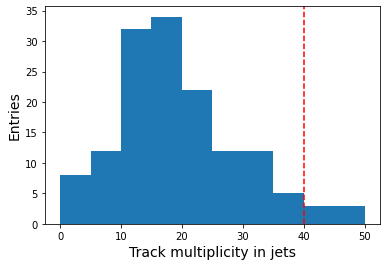

In [169]:
maxNumTrks = 40

plt.hist(nTrks)

ylim = plt.ylim()
plt.plot([maxNumTrks]*2,ylim,'r--')
plt.ylim(ylim)

plt.xlabel('Track multiplicity in jets',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.show()

Since the PU is so much higher for HL-LHC here than it was in Run 2, there should _probably_ be more tracks in the jet.

In [184]:
# B/c I'll append the IPs w/r.t. the PV at the end
tarr = np.zeros((len(jdf),maxNumTrks,len(tVars)+2)) 
tarr.shape

(143, 40, 11)

**To look up:** Numpy named arrays

**To do:** 
1. Check the jet -> track association w/ PF
2. Apply track cuts
3. Apply a sort

**Note:** The way the file is setup now, I'm going to need to do the track -> jet association _before_ applying the track cuts though.

In [172]:
jet_trk_idx[0][0]

<Array [1057, 1039, 1181, ... 1651, 1677, 1653] type='20 * int64'>

<img src="IP-defns.png" style="width:800px;height:300px;">

**Goal:** Revise so that everything is with respect to the PV.


**Looking at the left hand figure:**

$$ d_{0,x}^{PV} = d_0^{BS} \cos (\phi^{BS} - \frac{\pi}{2}) - PV_x$$

$$ d_{0,y}^{PV} = d_0^{BS} \sin (\phi^{BS} - \frac{\pi}{2}) - PV_y $$

$$d_0^{PV} = \sqrt{(d_{0,x}^{PV})^2 + (d_{0,y}^{PV})^2}$$


**The z IP is _easier_ b/c this is already the dimensions that the problem is in.**


$$z_0^{PV} = z_0^{BS} - PV_z$$


In [183]:
tVars

['d0', 'z0', 'var_d0', 'var_z0', 'qOverP', 'theta', 'phi', 'numPix', 'numSCT']

In [200]:
# Init some columns that we will fill in the for loop
tdf['d0_PV'] = 0
tdf['z0_PV'] = 0

k = 0 # counter to keep track of which jet we're on

# Loop over the evts
for ievt, evt_lev_links in tqdm(enumerate(jet_trk_idx)):

    # Calculate the IPs w/r.t. the PV
    d0x = tdf.loc[ievt,'d0'] * np.cos(tdf.loc[ievt,'phi'] - np.pi / 2) - edf.loc[ievt,'PV_x']
    d0y = tdf.loc[ievt,'d0'] * np.sin(tdf.loc[ievt,'phi'] - np.pi / 2) - edf.loc[ievt,'PV_y']
    
    tdf.loc[ievt,'d0_PV'] = np.sqrt(d0x**2 + d0y**2).values
    tdf.loc[ievt,'z0_PV'] =  tdf.loc[ievt,'z0'].values - edf.loc[ievt,'PV_z']
    
    # Loop over the jets
    for jlinks in evt_lev_links:
        
        nt = len(jlinks) # num of tracks associated to this jet
        
        # This is a np array for the track features
        # It has shape (num_trks_jet, num_trk_feat)
        trks_in_jet = tdf.loc[(ievt, jlinks),tVars+['d0_PV','z0_PV']].values 
        
        '''
        TO DO: Add  the track cuts and a trk sort
        '''
        
        
        # I think this will _also_ be where I calculate the lifetime signage 
        # w/r.t. the PV
    
        if nt < maxNumTrks:
            tarr[k,:nt] = trks_in_jet
        else:
            tarr[k] = trks_in_jet[:maxNumTrks]
            
        k += 1


5it [00:01,  4.31it/s]


In [201]:
tdf

prob        d0          z0     theta       phi    qOverP  \
entry subentry                                                             
0     0          1.0  0.068525 -113.233635  0.093817 -1.535720  0.000057   
      1          1.0 -0.111014  -27.396494  0.120725 -2.954081  0.000132   
      2          1.0 -0.138938   -4.618141  3.053917 -0.558245 -0.000128   
      3          1.0  0.010095  -28.699635  0.096940  1.596725  0.000133   
      4          1.0 -0.185778    0.131656  0.106381 -0.182650 -0.000138   
...              ...       ...         ...       ...       ...       ...   
4     2063       1.0 -9.970863  -76.061501  0.929902 -2.326607 -0.000767   
      2064       1.0 -2.115953  -22.095919  1.050627 -1.390253  0.000226   
      2065       1.0  3.493920  -46.917561  0.497837  0.670299  0.000464   
      2066       1.0 -7.444158  -22.577688  0.398879  1.161659  0.000135   
      2067      -1.0  5.163932 -110.862343  0.577442 -1.881277  0.000446   

                             t               z    var_d0     var_z0  ...  \
entry subentry                                                       ...   
0     0              -0.003707     -113.805328  0.007397   0.739145  ...   
      1              -0.323910      -26.607733  0.012864   0.788270  ...   
      2              -0.109046        1.746377  0.029869   3.538795  ...   
      3              -0.133718      -29.683847  0.019501   2.294250  ...   
      4              -0.109046        1.746377  0.017720   1.404823  ...   
...                        ...             ...       ...        ...  ...   
4     2063            0.027510      -80.349335  0.004433   0.007230  ...   
      2064        -1000.000000    -1000.000000  0.004179   0.004246  ...   
      2065        -1000.000000    -1000.000000  0.091547   0.371439  ...   
      2066        -1000.000000    -1000.000000  0.259312   1.307665  ...   
      2067     -1000000.000000 -1000000.000000  4.780300  18.665632  ...   

                           t60             t90            t120  \
entry subentry                                                   
0     0              -0.124720        0.077949       -0.025536   
      1              -0.332253       -0.552500       -0.442268   
      2              -0.210716        0.002434       -0.281718   
      3              -0.116003       -0.251258       -0.084557   
      4              -0.212083       -0.090307        0.009257   
...                        ...             ...             ...   
4     2063            0.048614       -0.054075        0.167804   
      2064     -1000000.000000 -1000000.000000 -1000000.000000   
      2065     -1000000.000000 -1000000.000000 -1000000.000000   
      2066     -1000000.000000 -1000000.000000 -1000000.000000   
      2067     -1000000.000000 -1000000.000000 -1000000.000000   

                          t180  numPix  numSCT  numPix1L  numPix2L     d0_PV  \
entry subentry                                                                 
0     0              -0.083562      21       0        11         5  0.063754   
      1              -0.194888      24       0        10         8  0.096761   
      2               0.069867      22       0        10         5  0.155947   
      3              -0.154639      21       0        10         4  0.023126   
      4               0.274864      21       0        10         6  0.202792   
...                        ...     ...     ...       ...       ...       ...   
4     2063            0.233847       5       8         1         1  9.964347   
      2064     -1000000.000000       5       9         0         2  2.111212   
      2065     -1000000.000000       4      10         0         1  3.487631   
      2066     -1000000.000000       2      15         0         0  7.450659   
      2067     -1000000.000000       0       6         0         0  5.170285   

                     z0_PV  
entry subentry              
0     0        -138.716446  
      1         -52.879299  
      2         -30.10

**Jet cuts**

Recall what we had from the FlavorTagPerformanceFramework:

- Jets with $p_T > 20$ GeV, $|\eta| < 2.5$
- JVT cut (0.2 for pflow jets with pt < 60 GeV and $|\eta| < 2.4$)
- Doesn't overlap with an electron or muon (implemented by the `jet_aliveAfterOR` and `jet_aliveAfterORmu` variables)

**Insight from Francesco:** Let's just use the HS jets (set with the `jet_isHS`, and technically this means the reco jet is within $\Delta R < 0.3$ from a truth jet).

In [29]:
jmask = (jdf['jet_pt'] > 20) & (np.abs(jdf['jet_eta']) < 2.5) & jdf['jet_isHS'].astype('bool')

## Visualize the variables we would cut on for the tracks

### Visualize

**Goal:** Plot the track features

In [187]:
# data has shape (nJets,maxNumTrks,nFeatures), so to sort out the mask,
# we need to find where the value is masked for a track over
# all of it's features.
tmask = ~ np.all(tarr == 0, axis=-1) # shape (nJets,nTrks)

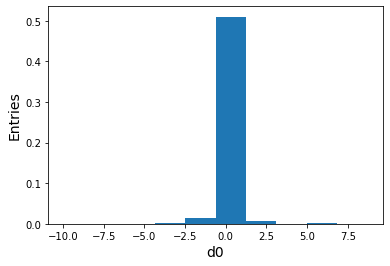

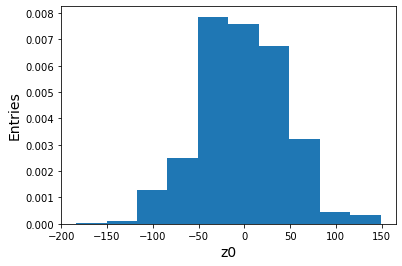

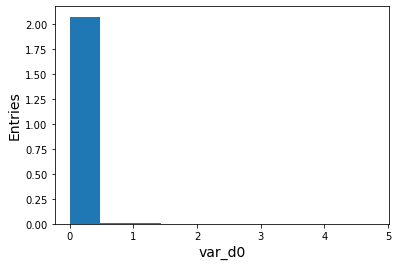

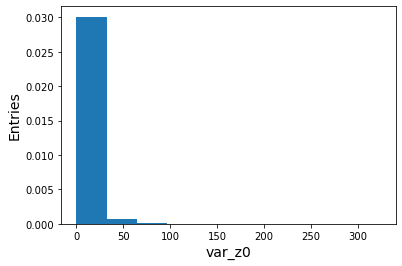

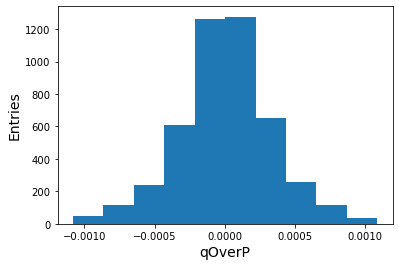

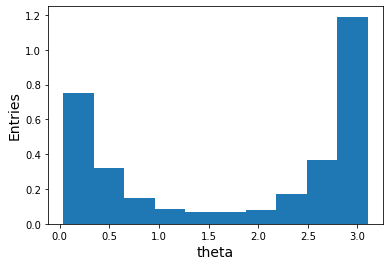

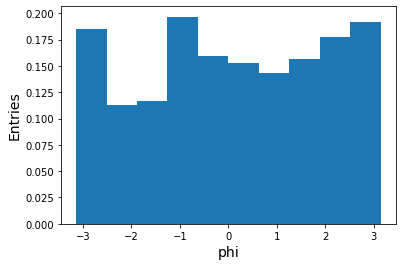

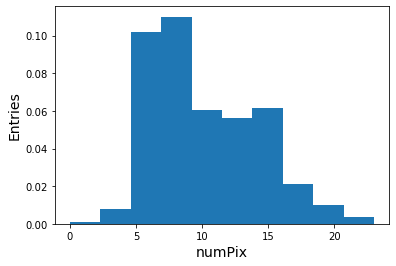

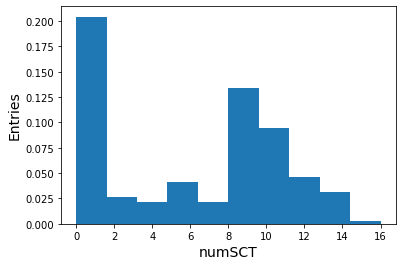

In [188]:
for i,v in enumerate(tVars):
    
    plt.figure()
    
    plt.hist(tarr[:,:,i][tmask],density=True)
    plt.xlabel(v,fontsize=14)
    plt.ylabel('Entries',fontsize=14)
    
    plt.show()
    

Woah -- this is a really big `track_z0`... is this the wrong variable??
(Like w/r.t. the BS instead of w/r.t. the PV?)

**Chat with Lorenzo:** Yep, this _is_ the `track_z0` w/r.t. the PV.

I added some code to try to calculate this with respect to the PV

**Sanity check:** Plot the IPs w/r.t. the beam spot and the PV to see if we got the implementation correct?

- Def should only look at H.S. jets for this plot
- Also breaking down by b, c, and light would be very interesting.

In [202]:
tarr[jmask,:,-2][tmask[jmask]]

array([1.20933257e-01, 4.68468992e-03, 1.60976518e-02, 1.01615198e-01,
       1.14457980e-02, 1.13856263e-01, 5.95556162e-02, 6.87380582e-02,
       1.95494401e+00, 8.68177973e-03, 1.19015026e+00, 2.98229933e-01,
       2.63221338e-02, 2.07212567e-01, 3.05096507e-01, 8.74079049e-01,
       4.82439280e-01, 8.95385861e-01, 3.49668451e-02, 1.05655074e+00,
       1.79489255e-01, 1.94645062e-01, 3.65010463e-02, 5.35758547e-02,
       1.16451327e-02, 5.40747959e-03, 8.06474965e-03, 8.33302513e-02,
       9.64448415e-03, 1.22857444e-01, 6.72650244e-03, 7.08836457e-03,
       6.70385063e-02, 8.59195888e-02, 2.90482957e-02, 1.90221727e-01,
       5.78732304e-02, 2.08635088e-02, 5.43654477e-03, 3.18182111e-02,
       3.61308083e-02, 4.60440032e-02, 6.59484230e-03, 8.91982689e-02,
       2.71387361e-02, 2.38753222e-02, 1.26704842e-01, 1.00189351e-01,
       1.01494479e+00, 2.11435378e-01, 1.77419126e-01, 1.66353390e-01,
       2.12949634e-01, 5.03704231e-03, 6.73642680e-02, 4.63474430e-02,
      

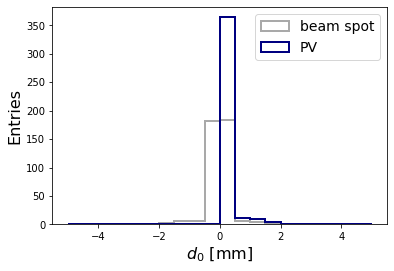

In [221]:
plt.hist(tarr[jmask,:,0][tmask[jmask]],20,(-5,5),histtype='step',lw=2,
         color='darkgrey',label='beam spot')
plt.hist(tarr[jmask,:,-2][tmask[jmask]],20,(-5,5),histtype='step',lw=2,
         color='navy',label='PV')
plt.xlabel('$d_0$ [mm]',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.legend(fontsize=14)

plt.show()

**Issue:** Rn $d_0$ is only positive... need to fix!!

But... this probably isn't the end of the world b/c we want to assign a lifetime sign anyways??


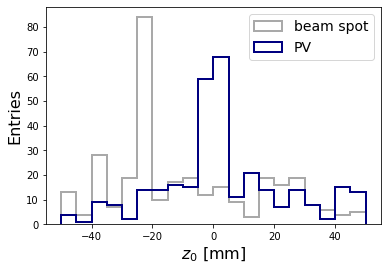

In [223]:
plt.hist(tarr[jmask,:,1][tmask[jmask]],20,(-50,50),histtype='step',lw=2,
         color='darkgrey',label='beam spot')
plt.hist(tarr[jmask,:,-1][tmask[jmask]],20,(-50,50),histtype='step',lw=2,
         color='navy',label='PV')
plt.xlabel('$z_0$ [mm]',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.legend(fontsize=14)

plt.show()

OK -- I think $z_0$ looks ok

**To do:** 
- Calculate the track variables with respect to the PV

**Need help:** How do we propagate the track errors?

- Calculate the lifetime sign

### ML preprocessing


**Scale the track features**

In [215]:
import json

In [216]:
def scale(data, var_names, savevars, filename='data/trk_scales.json', mask_value=0,
          jetData=None):
    '''
    
    Scaling function for the track features
    
    Args:
    -----
        data: a numpy array of shape (nb_events, nb_particles, n_variables)
        var_names: list of keys to be used for the model
        savevars: bool -- True for training, False for testinh
                  it decides whether we want to fit on data to find mean and std
                  or if we want to use those stored in the json file
        filename: string: Where to save the output
        mask_value: the value to mask when taking the avg and stdev

    Returns:
    --------
        modifies data in place, writes out scaling dictionary

    Reference: Taken from Micky's dataprocessing.py file in
    https://github.com/mickypaganini/RNNIP
    '''
    
    scale = {}

    # data has shape (nJets,maxNumTrks,nFeatures), so to sort out the mask,
    # we need to find where the value is masked for a track over
    # all of it's features.
    mask = ~ np.all(data == mask_value, axis=-1) # shape (nJets,nTrks)

    if savevars:

        # track variables
        for v, name in enumerate(var_names):
            print('Scaling feature {} of {} ({}).'.format(v + 1, len(var_names), name))
            f = data[:, :, v]
            slc = f[mask]
            m, s = slc.mean(), slc.std()
            slc -= m
            slc /= s
            data[:, :, v][mask] = slc.astype('float32')
            scale[name] = {'mean' : float(m), 'sd' : float(s)}
           
        # Jet variables
        if jetData is not None:
            scaler = StandardScaler(copy=False) # scale the data in place
            scaler.fit_transform(jetData)
            scale['jet_mean'] = scaler.mean_
            scale['jet_scale'] = scaler.scale_
            scale['jet_var'] = scaler.var_
            scale['n_samples_seen'] = scaler.n_samples_seen_
            
        with open(filename, 'w') as varfile:
            json.dump(scale, varfile)

    else:
        with open(filename, 'r') as varfile:
            varinfo = json.load(varfile)

        # track variables
        for v, name in enumerate(var_names):
            print('Scaling feature {} of {} ({}).'.format(v + 1, len(var_names), name))
            f = data[:, :, v]
            slc = f[mask]
            m = varinfo[name]['mean']
            s = varinfo[name]['sd']
            slc -= m
            slc /= s
            data[:, :, v][mask] = slc.astype('float32')
                        
        if jetData is not None:
            scaler = StandardScaler(copy=False) # scale the data in place
            varinfo['jet_mean'] = scaler.mean_
            varinfo['jet_scale'] = scaler.scale_
            varinfo['jet_var'] = scaler.var_
            varinfo['n_samples_seen'] = scaler.n_samples_seen_
            scaler.transform(jetData)

In [217]:
scaled_tarr = np.copy(tarr)
scale(scaled_tarr,tVars, True)

Scaling feature 1 of 2 (track_d0).
Scaling feature 2 of 2 (track_z0).


**Find the jet weights**

Althought GN1 does a "downsampling" procedure, to keep it _simple_ for starting, let's just apply some jet and track level weights.


In [245]:
def pTReweight(jet_df):
    '''
    Do the pT reweighting for the sample, and add a new col "sample_weight" to the jet_df

    Inputs:
    - jet_df: pandas dataframe w/ the jet level variables
    '''
    # Set the bin edged
    start, step = 0, 10 # GeV
    stop = np.max(jet_df.jet_pt)
    pT_edges = np.arange(start, stop+step, step)

    # Get the bin that each entry corresponds to
    x_ind = np.digitize(jet_df.jet_pt, pT_edges) - 1

    # Make the histograms
    l_hist, _ = np.histogram(jet_df[jet_df.jet_label==0].jet_pt, bins=pT_edges)
    c_hist, _ = np.histogram(jet_df[jet_df.jet_label==4].jet_pt, bins=pT_edges)
    b_hist, _ = np.histogram(jet_df[jet_df.jet_label==5].jet_pt, bins=pT_edges)

    # Normalize and add epsilon so that you never get a divide by 0 error
    epsilon = 1e-8
    l_hist = l_hist / np.sum(l_hist) + epsilon
    c_hist = c_hist / np.sum(c_hist) + epsilon
    b_hist = b_hist / np.sum(b_hist) + epsilon

    # Reweight the b-jets and c-jets to the l-jet pT (and maybe later eta) dist 
    jet_df['sample_weight'] = np.ones(len(jet_df))
    
    for pdg,ref_hist in zip([4,5],[c_hist,b_hist]):
        mi = (jet_df.jet_label==pdg)
        jet_df.loc[mi,'sample_weight'] = l_hist[x_ind[mi]] / ref_hist[x_ind[mi]]



In [246]:
pTReweight(jdf)

In [222]:
jdf.columns

Index(['jet_pt', 'jet_eta', 'jet_phi', 'jet_m', 'jet_q', 'jet_ptmatched_pt',
       'jet_ptmatched_eta', 'jet_ptmatched_phi', 'jet_ptmatched_m',
       'jet_drmatched_pt', 'jet_drmatched_eta', 'jet_drmatched_phi',
       'jet_drmatched_m', 'jet_isPU', 'jet_isHS', 'jet_label'],
      dtype='object')

**Save to a .h5 file**

In [ ]:
# Step 0: Process the string inputs for the vars in each norm sheme -> list
noNormVars = strToList(noNormStr)
logNormVars = strToList(logNormStr)
jointNormVars = strToList(jointNormStr)

# Step 1: Select the relevant variables
inpts = noNormVars + logNormVars + jointNormVars

# Check that all of the requested inputs are actually vars in trk_xr
trkInputs = list(trk_xr.coords['var'].values)
for inpt in inpts:
    if inpt not in trkInputs:
        raise ValueError('In prepareForKeras(): requested var {} not in trk_xr'.format(inpt))

X = trk_xr.loc[:,:,inpts].values
X_jet = jet_df[jetVars]
ix = trk_xr.indexes['jet']
print("X.shape = ", X.shape)

# Keep track of which tracks in the jet are masked
mask = ~ np.all(X == 0, axis=-1)
print("mask",mask.shape)

# Take the log of the desired variables
for i, v in enumerate(logNormVars):
    j = i + len(noNormVars)
    X[:,:,j][mask] = np.log(np.where(X[:,:,j][mask]==0,1e-8,X[:,:,j][mask]))

# Step 2: Train / test split
pdg_to_class = {0:0, 4:1, 5:2, 15:3}
y = jet_df.jet_label.replace(pdg_to_class).values


random_seed = 25
X_train, X_test, y_train, y_test, ix_train, ix_test, w_train, w_test, = \
    train_test_split(X, y, ix, jet_df.sample_weight, test_size=0.333,
                     random_state=random_seed)

# Step 3: Normalize the requested inputs

# Get a string representing the variables getting scaled
varTag = "_".join(noNormVars) if len(noNormVars) != 0 else ''
varTag += '_logNorm_' + "_".join(logNormVars) if len(logNormVars) != 0 else ''
varTag += '_norm_' + "_".join(jointNormVars) if len(jointNormVars) != 0 else ''

# Scale the vars and save the files
if len(scalingfile) == 0:
    scalingfile = f"data/scale_{varTag}.json"
print("scalingfile",scalingfile)

if len(logNormVars)+len(jointNormVars) > 0:

    scale(X_train[:,:,len(noNormVars):], logNormVars+jointNormVars, savevars=True,  filename=scalingfile)
    scale(X_test[:,:, len(noNormVars):], logNormVars+jointNormVars, savevars=False, filename=scalingfile)

myDict = {
    "X_train" : X_train,
    "y_train" : y_train,
    "ix_train" : ix_train,
    "weights_train" : w_train,

    "X_test" : X_test,
    "y_test" : y_test,
    "ix_test" : ix_test,
    "weights_test" : w_test,
}

# Step 4: Save as h5py files
outputFile = 'data/output.hdf5'
print("Saving datasets in {}".format(outputFile))
f = h5py.File(subDir,outputFile, 'w')

for key, val in myDict.items():
    f.create_dataset(key, data=val)

f.close()